In [82]:
import torch
import jovian
import torchvision
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import random_split
from torch.utils.data import DataLoader, TensorDataset, random_split

In [83]:
batch_size = 100
learning_rate = 0.001

# Other constants
input_size = 3*32*32
num_classes = 10

In [84]:
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])

testset = torchvision.datasets.CIFAR10(root='D:\PyTorch\cifar-10-python', train=False,download=False, transform=transform)
trainvalset = torchvision.datasets.CIFAR10(root='D:\PyTorch\cifar-10-python', train=True,download=False, transform=transform)
trainset, valset = torch.utils.data.random_split(trainvalset, [45000, 5000]) # 10% for validation

train_loader = torch.utils.data.DataLoader(trainset, batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size, shuffle=False)
val_loader = torch.utils.data.DataLoader(valset, batch_size, shuffle=False)

In [143]:
'''
transform_train = transforms.Compose([transforms.Resize((32,32)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(10),
                                      transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
                                      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])


transform = transforms.Compose([transforms.Resize((32,32)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])
training_dataset = CIFAR10(root='D:\PyTorch\cifar-10-python', train=True, download=True, transform=transform_train)
train_ds, val_ds = random_split(training_dataset, [40000, 10000])
test_ds = CIFAR10(root='D:\PyTorch\cifar-10-python', train=False, download=True, transform=transform)

train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size , shuffle = False)
test_loader = DataLoader(test_ds, batch_size, shuffle=False)
'''

"\ntransform_train = transforms.Compose([transforms.Resize((32,32)),\n                                      transforms.RandomHorizontalFlip(),\n                                      transforms.RandomRotation(10),\n                                      transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),\n                                      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),\n                                      transforms.ToTensor(),\n                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))\n                               ])\n\n\ntransform = transforms.Compose([transforms.Resize((32,32)),\n                               transforms.ToTensor(),\n                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))\n                               ])\ntraining_dataset = CIFAR10(root='D:\\PyTorch\\cifar-10-python', train=True, download=True, transform=transform_train)\ntrain_ds, val_ds = random_split

Label: 9


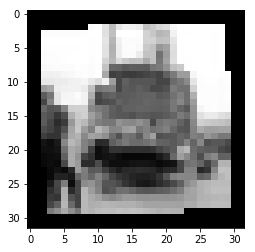

In [85]:
image, label = train_ds[0]
plt.imshow(image[0], cmap='gray')
print('Label:', label)

In [5]:
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

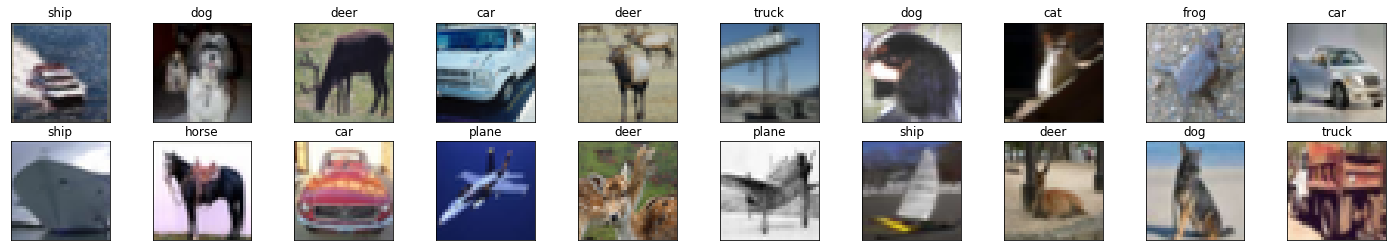

In [86]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
dataiter = iter(train_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title(classes[labels[idx].item()])

In [163]:
class CifarModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size,  num_classes)
    def forward(self, xb):
        xb = xb.view(-1, 3*32*32)
        #print(xb.shape)
        #xb = xb.reshape(-1, 784)
        #print(xb.shape)
        out = torch.relu(self.linear(xb))
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    
model = CifarModel()

In [173]:
class CifarModel2(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size,  num_classes)
    def forward(self, xb):
        xb = xb.view(-1, 3*32*32)
        #print(xb.shape)
        #xb = xb.reshape(-1, 784)
        #print(xb.shape)
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    
model = CifarModel2()

In [174]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history
evaluate(model, val_loader)

{'val_loss': 2.359766721725464, 'val_acc': 0.08079998195171356}

In [89]:
history = fit(5, 0.01, model, train_loader, val_loader)

Epoch [0], val_loss: 1.8003, val_acc: 0.3870
Epoch [1], val_loss: 1.7583, val_acc: 0.4100
Epoch [2], val_loss: 1.7431, val_acc: 0.4126
Epoch [3], val_loss: 1.7354, val_acc: 0.4166
Epoch [4], val_loss: 1.7278, val_acc: 0.4090


In [90]:
epochs = 10
lr = 7e-5
history1 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [0], val_loss: 1.7219, val_acc: 0.4144
Epoch [1], val_loss: 1.7198, val_acc: 0.4182
Epoch [2], val_loss: 1.7189, val_acc: 0.4174
Epoch [3], val_loss: 1.7185, val_acc: 0.4174
Epoch [4], val_loss: 1.7183, val_acc: 0.4170
Epoch [5], val_loss: 1.7181, val_acc: 0.4180
Epoch [6], val_loss: 1.7181, val_acc: 0.4180
Epoch [7], val_loss: 1.7180, val_acc: 0.4192
Epoch [8], val_loss: 1.7179, val_acc: 0.4200
Epoch [9], val_loss: 1.7178, val_acc: 0.4204


In [139]:
epochs = 10
lr = 1e-2
history1 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [0], val_loss: 1.7895, val_acc: 0.3968
Epoch [1], val_loss: 1.7646, val_acc: 0.4012
Epoch [2], val_loss: 1.7499, val_acc: 0.4146
Epoch [3], val_loss: 1.7309, val_acc: 0.4162
Epoch [4], val_loss: 1.7245, val_acc: 0.4146
Epoch [5], val_loss: 1.7227, val_acc: 0.4176
Epoch [6], val_loss: 1.7150, val_acc: 0.4242
Epoch [7], val_loss: 1.7172, val_acc: 0.4226
Epoch [8], val_loss: 1.7165, val_acc: 0.4154
Epoch [9], val_loss: 1.7135, val_acc: 0.4246


In [162]:
epochs = 10
lr = .05
history1 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [0], val_loss: 2.0632, val_acc: 0.3544
Epoch [1], val_loss: 2.0450, val_acc: 0.3642
Epoch [2], val_loss: 2.0360, val_acc: 0.3690
Epoch [3], val_loss: 2.0290, val_acc: 0.3716
Epoch [4], val_loss: 2.0226, val_acc: 0.3782
Epoch [5], val_loss: 2.0186, val_acc: 0.3814
Epoch [6], val_loss: 2.0146, val_acc: 0.3838
Epoch [7], val_loss: 2.0121, val_acc: 0.3856
Epoch [8], val_loss: 2.0104, val_acc: 0.3852
Epoch [9], val_loss: 2.0081, val_acc: 0.3872


In [168]:
epochs = 5
lr = 5e-7
history1 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [0], val_loss: 1.7104, val_acc: 0.4312
Epoch [1], val_loss: 1.7103, val_acc: 0.4312
Epoch [2], val_loss: 1.7103, val_acc: 0.4310
Epoch [3], val_loss: 1.7103, val_acc: 0.4310
Epoch [4], val_loss: 1.7103, val_acc: 0.4310


In [166]:
epochs = 5
lr = .001
history2 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [0], val_loss: 1.7209, val_acc: 0.4236
Epoch [1], val_loss: 1.7197, val_acc: 0.4258
Epoch [2], val_loss: 1.7202, val_acc: 0.4294
Epoch [3], val_loss: 1.7188, val_acc: 0.4284
Epoch [4], val_loss: 1.7179, val_acc: 0.4276


In [169]:
epochs = 5
lr = 1e-2
history3 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [0], val_loss: 1.7121, val_acc: 0.4250
Epoch [1], val_loss: 1.7082, val_acc: 0.4312
Epoch [2], val_loss: 1.7105, val_acc: 0.4266
Epoch [3], val_loss: 1.7099, val_acc: 0.4208
Epoch [4], val_loss: 1.7072, val_acc: 0.4238


In [170]:
history4 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.6998, val_acc: 0.4314
Epoch [1], val_loss: 1.6994, val_acc: 0.4318
Epoch [2], val_loss: 1.6996, val_acc: 0.4286
Epoch [3], val_loss: 1.6994, val_acc: 0.4290
Epoch [4], val_loss: 1.6985, val_acc: 0.4318


In [175]:
history5 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.9491, val_acc: 0.3312
Epoch [1], val_loss: 1.8814, val_acc: 0.3646
Epoch [2], val_loss: 1.8484, val_acc: 0.3756
Epoch [3], val_loss: 1.8277, val_acc: 0.3848
Epoch [4], val_loss: 1.8137, val_acc: 0.3890


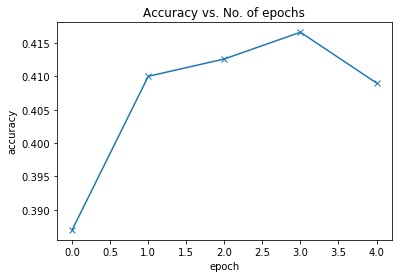

In [171]:
accuracies = [r['val_acc'] for r in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

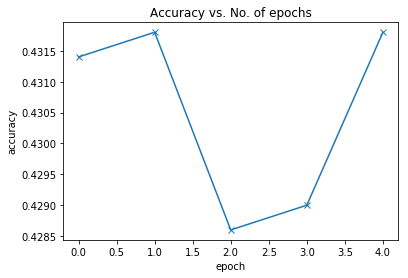

In [179]:
accuracies = [r['val_acc'] for r in history4]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

In [150]:
# Evaluate on test dataset
result = evaluate(model, test_loader)
result

{'val_loss': 2.006443977355957, 'val_acc': 0.358100026845932}

In [151]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Label: 8 , Predicted: 9


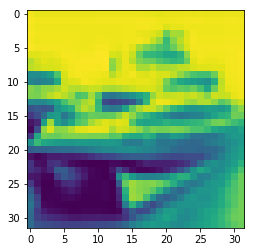

In [152]:
img, label = test_ds[1]
plt.imshow(img[0])
print('Label:', label, ', Predicted:', predict_image(img, model))

In [144]:
jovian.commit(project='cifar-logistic', environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "harsh-hr305/cifar-logistic" on https://jovian.ml/
[jovian] Uploading notebook..
[jovian] Committed successfully! https://jovian.ml/harsh-hr305/cifar-logistic


'https://jovian.ml/harsh-hr305/cifar-logistic'

In [181]:
jovian.log_metrics(val_acc=history[-1]['val_acc'], val_loss=history[-1]['val_loss'])

[jovian] Metrics logged.


Shape: torch.Size([3, 32, 32])
Label: 3


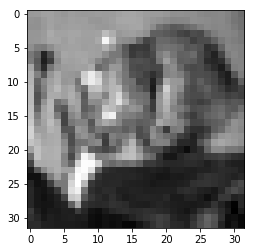

In [183]:
img, label = testset[0]
plt.imshow(img[0], cmap='gray')
print('Shape:', img.shape)
print('Label:', label)

In [184]:
img.unsqueeze(0).shape

torch.Size([1, 3, 32, 32])

Label: 3 , Predicted: 6


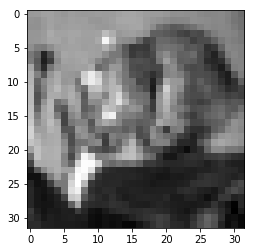

In [186]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

img, label = testset[0]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 8 , Predicted: 9


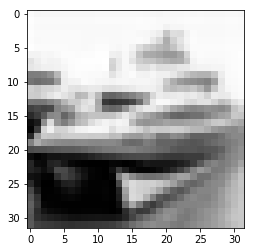

In [187]:
img, label = testset[1]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 6 , Predicted: 6


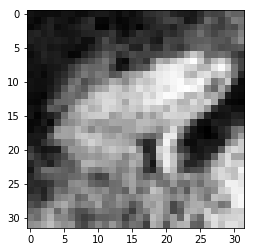

In [188]:
img, label = testset[19]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 9 , Predicted: 9


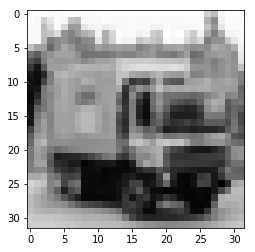

In [190]:
img, label = testset[11]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

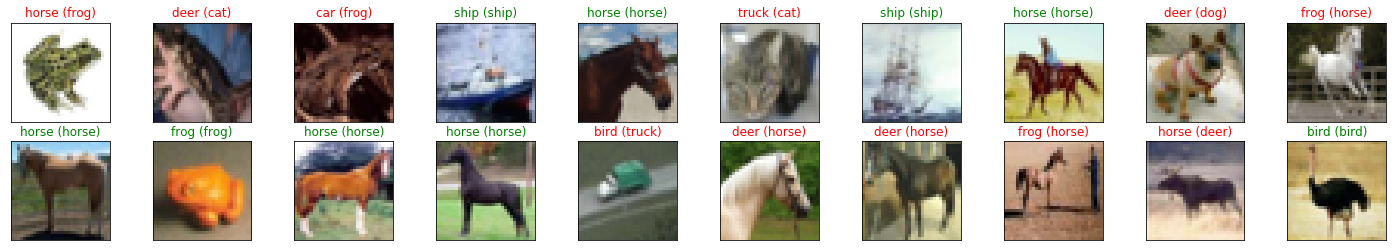

In [192]:
import numpy as np
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image


classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

dataiter = iter(val_loader)
images, labels = dataiter.next()
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title("{} ({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color=("green" if preds[idx]==labels[idx] else "red"))